<a href="https://colab.research.google.com/github/JM3309/Projects/blob/master/credit_risk_model_PDmodel_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit risk model



The dataset contains all available data for more than 800,000 consumer loans issued from 2007 to 2018 by Lending Club: a large US peer-to-peer lending company. There are several different versions of this dataset. You can find the datasource here: https://www.kaggle.com/wordsforthewise/lending-club/notebooks.




We divided the data into two periods because we assume that some data are available at the moment when we need to build Expected Loss models, and some data comes from applications after. Later, we investigate whether the applications we have after we built the Probability of Default (PD) model have similar characteristics with the applications we used to build the PD model.

In [1]:
pip install boto3

In [2]:
import numpy as np
import pandas as pd
import boto3
import botocore
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Read data from s3 bucket

In [3]:

session = boto3.session.Session(region_name='us-east-1')
s3 = boto3.resource('s3', aws_access_key_id='xxxxxxxxxxxxxxxx',    #put your own aws access key id
         aws_secret_access_key= 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')  #your own aws secret access key


"\nsession = boto3.session.Session(region_name='us-east-1')\ns3 = boto3.resource('s3', aws_access_key_id='xxxxxxxxxxxxxxxx',    #put your own aws access key id\n         aws_secret_access_key= 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')  #your own aws secret access key\n\n"

In [4]:
bucket = s3.Bucket('ml-project-jm3309')
#bucket.download_file(Key='credit-risk-model/loan_data_2007_2014.csv',Filename='/tmp/helloworld.cli.downloadedtxt')
s3file = bucket.Object(key='credit-risk-model/loan_data_2007_2014.csv')
streaming_body = s3file.get()['Body']

In [5]:
loan_data_backup = pd.read_csv(streaming_body)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
loan_data = loan_data_backup.copy()

### data basic information

In [7]:
loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
loan_data.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [9]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [10]:
loan_data.shape

(466285, 75)

## Prepoccessing the data

### Prepoccesing the continuous data

**1. emp_length**

In [11]:
loan_data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [12]:
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',  str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')

In [13]:
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])

In [14]:
type(loan_data['emp_length_int'][0])

numpy.float64

**2. earliest_cr_line**

In [15]:
loan_data['earliest_cr_line']

0         Jan-85
1         Apr-99
2         Nov-01
3         Feb-96
4         Jan-96
           ...  
466280    Apr-03
466281    Jun-97
466282    Dec-01
466283    Feb-03
466284    Feb-00
Name: earliest_cr_line, Length: 466285, dtype: object

In [16]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')

In [17]:
# Assume we are now in December 2017
# We calculate the difference between two dates in months, turn it to numeric datatype and round it.
loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))

In [18]:
loan_data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

**Date from 1969 and before are not being converted well, 
 and negative differences are being calculated.**

In [19]:
loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][loan_data['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0
...,...,...,...
464003,Jan-68,2068-01-01,-601.0
464260,Jul-66,2066-07-01,-583.0
465100,Oct-67,2067-10-01,-598.0
465500,Sep-67,2067-09-01,-597.0


In [20]:
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
min(loan_data['mths_since_earliest_cr_line'])

73.0

**3.term**

In [22]:
loan_data['term'].describe()

count         466285
unique             2
top        36 months
freq          337953
Name: term, dtype: object

In [23]:
loan_data['term']

0          36 months
1          60 months
2          36 months
3          36 months
4          60 months
             ...    
466280     60 months
466281     60 months
466282     60 months
466283     36 months
466284     36 months
Name: term, Length: 466285, dtype: object

In [24]:
loan_data['term_int']=pd.to_numeric(loan_data['term'].str.replace(' months',''))

In [25]:
type(loan_data['term_int'][0])

numpy.int64

**4. issue_d_date**

In [26]:
# Assume we are now in December 2017
# Extracts the date and the time from a string variable that is in a given format.
# We calculate the difference between two dates in months, turn it to numeric datatype and round it.
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
loan_data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['issue_d_date']) / np.timedelta64(1, 'M')))
loan_data['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

### Prepoccessing the discrete variables

In [27]:
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]

In [28]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [29]:
loan_data_dummies.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,...,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [30]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)

### missing value

In [31]:
missing_col=loan_data.isnull().sum().sort_values(ascending=False)

In [32]:
missing_col[missing_col > 0]

mths_since_rcnt_il             466285
dti_joint                      466285
all_util                       466285
open_rv_12m                    466285
inq_fi                         466285
total_cu_tl                    466285
il_util                        466285
annual_inc_joint               466285
verification_status_joint      466285
max_bal_bc                     466285
inq_last_12m                   466285
total_bal_il                   466285
open_acc_6m                    466285
open_il_6m                     466285
open_il_12m                    466285
open_il_24m                    466285
open_rv_24m                    466285
mths_since_last_record         403647
mths_since_last_major_derog    367311
desc                           340302
mths_since_last_delinq         250351
next_pymnt_d                   227214
total_rev_hi_lim                70276
tot_coll_amt                    70276
tot_cur_bal                     70276
emp_title                       27588
emp_length  

In [33]:
loan_data.drop(['mths_since_rcnt_il','dti_joint','all_util','open_rv_12m',
                'inq_fi','total_cu_tl','il_util','annual_inc_joint',
                'verification_status_joint','max_bal_bc','inq_last_12m',
                'total_bal_il','open_acc_6m','open_il_6m','open_il_12m',
                'open_il_24m','open_rv_24m','mths_since_last_record'],axis=1,inplace=True)

In [34]:
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)
loan_data['earliest_cr_line'].fillna(0, inplace=True)
loan_data['last_pymnt_d'].fillna(0, inplace=True)

In [35]:
missing_col=loan_data.isnull().sum().sort_values(ascending=False)
missing_col[missing_col > 0]

mths_since_last_major_derog    367311
desc                           340302
mths_since_last_delinq         250351
next_pymnt_d                   227214
tot_coll_amt                    70276
tot_cur_bal                     70276
emp_title                       27588
emp_length                      21008
revol_util                        340
collections_12_mths_ex_med        145
last_credit_pull_d                 42
earliest_cr_line_date              29
title                              20
dtype: int64

## PD model

### Data preparation

In [36]:
loan_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In the loan status shows above, we define:

*   Charged Off
*    Default
*   Does not meet the credit policy. Status:Charged Off
*     Late (31-120 days)

as default status.                                     

In [37]:
loan_data['loan_status'].value_counts()/loan_data['loan_status'].count()

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

**Define the good cases and the default cases.**

In [38]:
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)

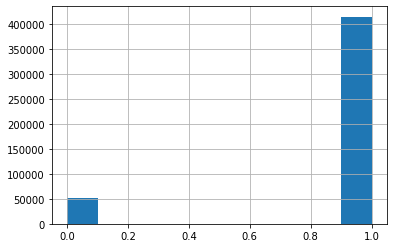

In [39]:
loan_data['good_bad'].hist()

### prepoccessing the discrete variables

In [40]:
x=loan_data.drop('good_bad',axis=1)
y=loan_data['good_bad']

In [41]:
import PD_model 

1.grade

In [42]:
df_temp = PD_model.PD.WOE_discrete(x, 'grade', y)
df_temp = PD_model.PD.IV(df_temp)

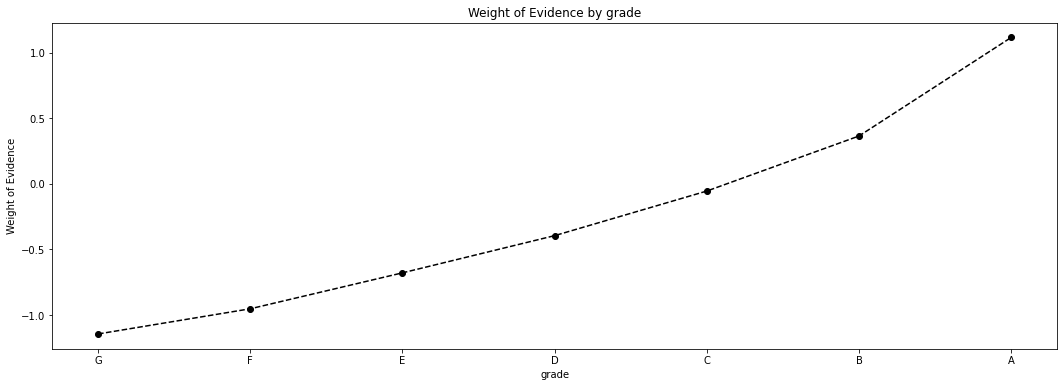

In [43]:
PD_model.PD.plot_by_woe(df_temp)

**create dummy variables**

2.addr_state

In [44]:
x['addr_state'].unique()

array(['AZ', 'GA', 'IL', 'CA', 'OR', 'NC', 'TX', 'VA', 'MO', 'CT', 'UT',
       'FL', 'NY', 'PA', 'MN', 'NJ', 'KY', 'OH', 'SC', 'RI', 'LA', 'MA',
       'WA', 'WI', 'AL', 'CO', 'KS', 'NV', 'AK', 'MD', 'WV', 'VT', 'MI',
       'DC', 'SD', 'NH', 'AR', 'NM', 'MT', 'HI', 'WY', 'OK', 'DE', 'MS',
       'TN', 'IA', 'NE', 'ID', 'IN', 'ME'], dtype=object)

In [45]:
df_temp = PD_model.PD.WOE_discrete(x, 'addr_state', y)
df_temp = PD_model.PD.IV(df_temp)

In [46]:
if ['addr_state:ND'] in x.columns.values:
    pass
else:
    x['addr_state:ND'] = 0

In [47]:
# We create the following categories:
# 'ND' 'NE' 'IA' NV' 'FL' 'HI' 'AL'
# 'NM' 'VA'
# 'NY'
# 'OK' 'TN' 'MO' 'LA' 'MD' 'NC'
# 'CA'
# 'UT' 'KY' 'AZ' 'NJ'
# 'AR' 'MI' 'PA' 'OH' 'MN'
# 'RI' 'MA' 'DE' 'SD' 'IN'
# 'GA' 'WA' 'OR'
# 'WI' 'MT'
# 'TX'
# 'IL' 'CT'
# 'KS' 'SC' 'CO' 'VT' 'AK' 'MS'
# 'WV' 'NH' 'WY' 'DC' 'ME' 'ID'

x['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([x['addr_state:ND'], x['addr_state:NE'],x['addr_state:IA'], x['addr_state:NV'],x['addr_state:FL'], x['addr_state:HI'], x['addr_state:AL']])
x['addr_state:NM_VA'] = sum([x['addr_state:NM'], x['addr_state:VA']])
x['addr_state:OK_TN_MO_LA_MD_NC'] = sum([x['addr_state:OK'], x['addr_state:TN'],x['addr_state:MO'], x['addr_state:LA'],x['addr_state:MD'], x['addr_state:NC']])                                            
x['addr_state:UT_KY_AZ_NJ'] = sum([x['addr_state:UT'], x['addr_state:KY'],x['addr_state:AZ'], x['addr_state:NJ']])
x['addr_state:AR_MI_PA_OH_MN'] = sum([x['addr_state:AR'], x['addr_state:MI'],x['addr_state:PA'], x['addr_state:OH'],x['addr_state:MN']])
x['addr_state:RI_MA_DE_SD_IN'] = sum([x['addr_state:RI'],x['addr_state:MA'],x['addr_state:DE'], x['addr_state:SD'], x['addr_state:IN']])
x['addr_state:GA_WA_OR'] = sum([x['addr_state:GA'], x['addr_state:WA'], x['addr_state:OR']])                                       
x['addr_state:WI_MT'] = sum([x['addr_state:WI'], x['addr_state:MT']])
x['addr_state:IL_CT'] = sum([x['addr_state:IL'], x['addr_state:CT']])
x['addr_state:KS_SC_CO_VT_AK_MS'] = sum([x['addr_state:KS'], x['addr_state:SC'],x['addr_state:CO'],x['addr_state:VT'],x['addr_state:AK'], x['addr_state:MS']])
x['addr_state:WV_NH_WY_DC_ME_ID'] = sum([x['addr_state:WV'], x['addr_state:NH'],x['addr_state:WY'],x['addr_state:DC'],x['addr_state:ME'], x['addr_state:ID']])
                                                                                        

3.verification_status

In [48]:
x['verification_status'].unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

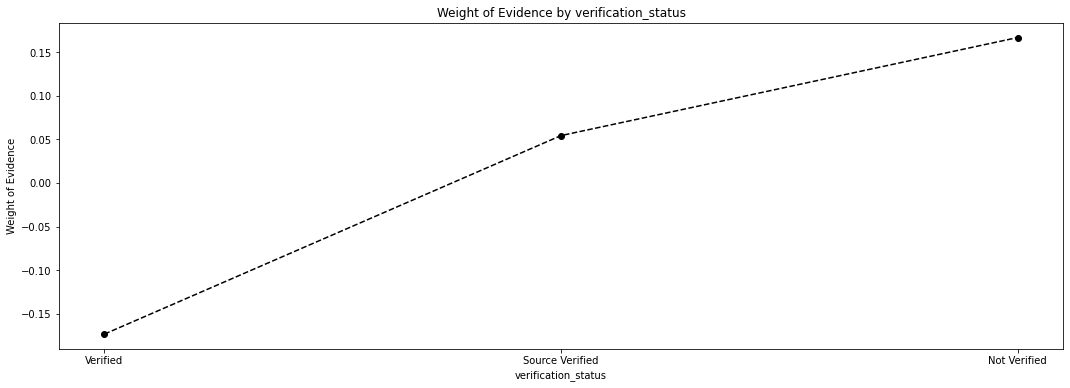

In [49]:
df_temp = PD_model.PD.WOE_discrete(x, 'verification_status', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp)

4.purpose

In [50]:
x['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

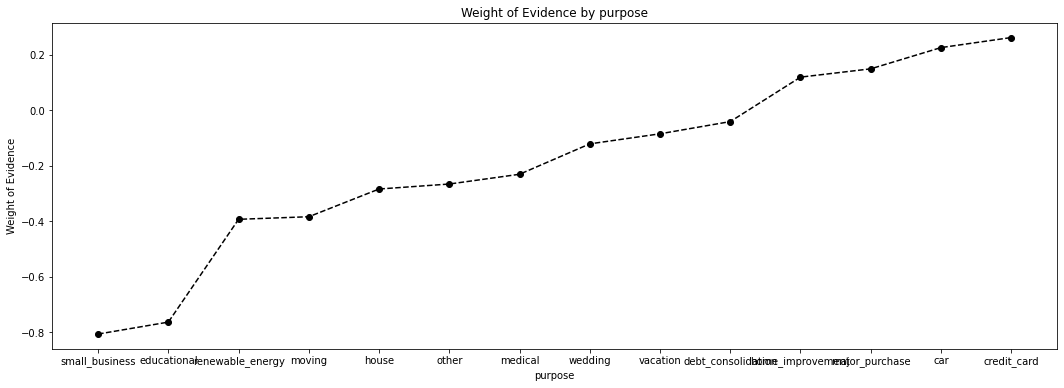

In [51]:
df_temp = PD_model.PD.WOE_discrete(x,'purpose', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp)

In [52]:
# We create the following categories:
# 'educational', 'small_business', 'wedding', 'renewable_energy', 'moving', 'house' in one category: 'educ__sm_b__wedd__ren_en__mov__house'
# 'other', 'medical', 'vacation' in one category: 'oth__med__vacation'
# 'major_purchase', 'car', 'home_improvement' in one category: 'major_purch__car__home_impr'
# 'debt_consolidtion'
# 'credit_card'

x['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([x['purpose:educational'], x['purpose:small_business'],
                                                                 x['purpose:wedding'], x['purpose:renewable_energy'],
                                                                 x['purpose:moving'], x['purpose:house']])
x['purpose:oth__med__vacation'] = sum([x['purpose:other'], x['purpose:medical'],x['purpose:vacation']])                                            
x['purpose:major_purch__car__home_impr'] = sum([x['purpose:major_purchase'], x['purpose:car'],x['purpose:home_improvement']])
                                                        

5.initial_list_status

In [53]:
x['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

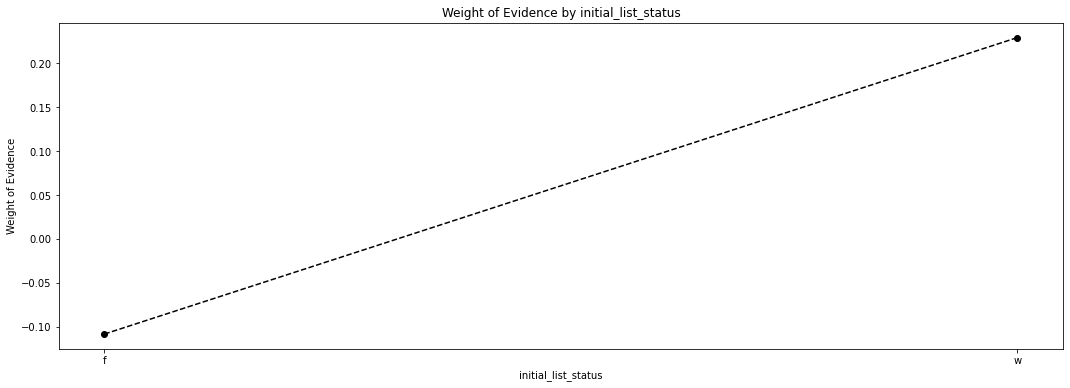

In [54]:
df_temp = PD_model.PD.WOE_discrete(x,'initial_list_status', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp)

### Prepoccessing the continuous variables

1. term_int

In [55]:
x['term_int'].unique()

array([36, 60])

In [56]:
df_temp = PD_model.PD.WOE_discrete(x,['term_int'], y)
df_temp = PD_model.PD.IV(df_temp)

In [57]:
x['term:36'] = np.where((x['term_int'] == 36), 1, 0)
x['term:60'] = np.where((x['term_int'] == 60), 1, 0)

2.emp_length_int

In [58]:
x['emp_length_int'].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7.])

In [59]:
df_temp = PD_model.PD.WOE_discrete(x,['emp_length_int'], y)
df_temp = PD_model.PD.IV(df_temp)

In [60]:
x['emp_length:0'] = np.where(x['emp_length_int'].isin([0]), 1, 0)
x['emp_length:1'] = np.where(x['emp_length_int'].isin([1]), 1, 0)
x['emp_length:2-4'] = np.where(x['emp_length_int'].isin(range(2, 5)), 1, 0)
x['emp_length:5-6'] = np.where(x['emp_length_int'].isin(range(5, 7)), 1, 0)
x['emp_length:7-9'] = np.where(x['emp_length_int'].isin(range(7, 10)), 1, 0)
x['emp_length:10'] = np.where(x['emp_length_int'].isin([10]), 1, 0)

3.mths_since_issue_d

In [61]:
x['mths_since_issue_d'].unique()

array([ 72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.])

In [62]:
x['mths_since_issue_d_factor'] = pd.cut(x['mths_since_issue_d'], 90) #split the variable into 90 categories.
df_temp = PD_model.PD.WOE_discrete(x,['mths_since_issue_d'], y)
df_temp = PD_model.PD.IV(df_temp)

In [63]:
x['mths_since_issue_d:<38'] = np.where(x['mths_since_issue_d'].isin(range(38)), 1, 0)
x['mths_since_issue_d:38-39'] = np.where(x['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
x['mths_since_issue_d:40-41'] = np.where(x['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
x['mths_since_issue_d:42-48'] = np.where(x['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
x['mths_since_issue_d:49-52'] = np.where(x['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
x['mths_since_issue_d:53-64'] = np.where(x['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
x['mths_since_issue_d:65-84'] = np.where(x['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
x['mths_since_issue_d:>84'] = np.where(x['mths_since_issue_d'].isin(range(85, int(x['mths_since_issue_d'].max()))), 1, 0)

4.int_rate

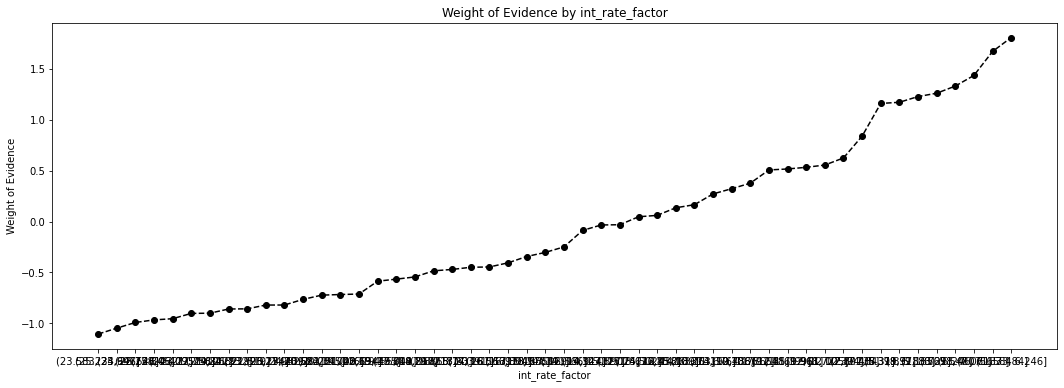

In [64]:
x['int_rate_factor'] = pd.cut(x['int_rate'], 50) #split the variable into 90 categories.
df_temp = PD_model.PD.WOE_discrete(x,['int_rate_factor'], y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp)

In [65]:
x['int_rate:<9.548'] = np.where((x['int_rate'] <= 9.548), 1, 0)
x['int_rate:9.548-12.025'] = np.where((x['int_rate'] > 9.548) & (x['int_rate'] <= 12.025), 1, 0)
x['int_rate:12.025-15.74'] = np.where((x['int_rate'] > 12.025) & (x['int_rate'] <= 15.74), 1, 0)
x['int_rate:15.74-20.281'] = np.where((x['int_rate'] > 15.74) & (x['int_rate'] <= 20.281), 1, 0)
x['int_rate:>20.281'] = np.where((x['int_rate'] > 20.281), 1, 0)

5.funded_amnt

In [66]:
x['funded_amnt_factor'] = pd.cut(x['funded_amnt'], 50)
df_temp = PD_model.PD.WOE_discrete(x,['funded_amnt_factor'], y)
df_temp = PD_model.PD.IV(df_temp)

6.mths_since_earliest_cr_line

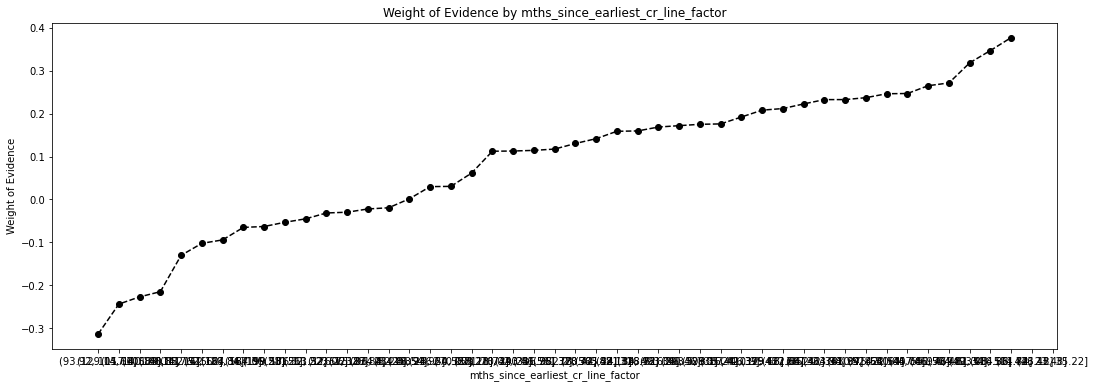

In [67]:
x['mths_since_earliest_cr_line_factor'] = pd.cut(x['mths_since_earliest_cr_line'], 50)
df_temp = PD_model.PD.WOE_discrete(x,['mths_since_earliest_cr_line_factor'], y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp)

In [68]:
x['mths_since_earliest_cr_line:<140'] = np.where(x['mths_since_earliest_cr_line_factor'].isin(range(140)), 1, 0)
x['mths_since_earliest_cr_line:141-164'] = np.where(x['mths_since_earliest_cr_line_factor'].isin(range(140, 165)), 1, 0)
x['mths_since_earliest_cr_line:165-247'] = np.where(x['mths_since_earliest_cr_line_factor'].isin(range(165, 248)), 1, 0)
x['mths_since_earliest_cr_line:248-270'] = np.where(x['mths_since_earliest_cr_line_factor'].isin(range(248, 271)), 1, 0)
x['mths_since_earliest_cr_line:271-352'] = np.where(x['mths_since_earliest_cr_line_factor'].isin(range(271, 353)), 1, 0)
x['mths_since_earliest_cr_line:>352'] = np.where(x['mths_since_earliest_cr_line'].isin(range(353, int(x['mths_since_earliest_cr_line'].max()))), 1, 0)

7.delinq_2yrs

/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


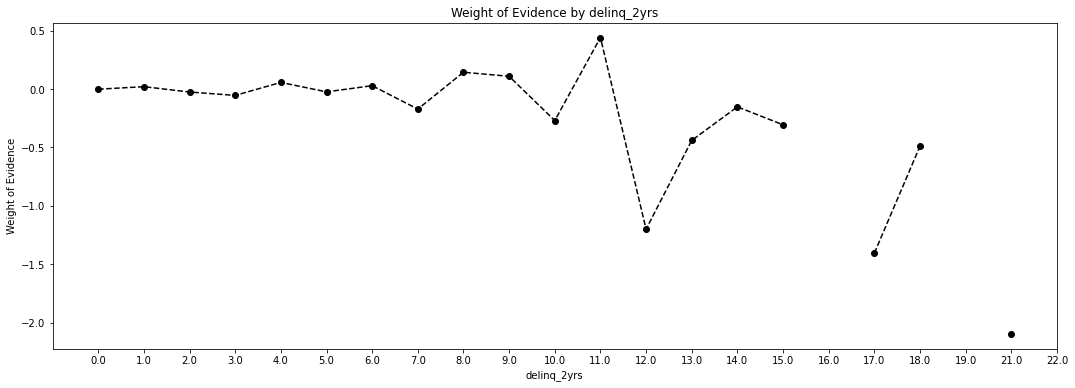

In [69]:
df_temp = PD_model.PD.WOE_continuous(x, 'delinq_2yrs', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp)

In [70]:
# Categories: 0, 1-3, >=4
x['delinq_2yrs:0'] = np.where((x['delinq_2yrs'] == 0), 1, 0)
x['delinq_2yrs:1-3'] = np.where((x['delinq_2yrs'] >= 1) & (x['delinq_2yrs'] <= 3), 1, 0)
x['delinq_2yrs:>=4'] = np.where((x['delinq_2yrs'] >= 9), 1, 0)

8.inq_last_6mths

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


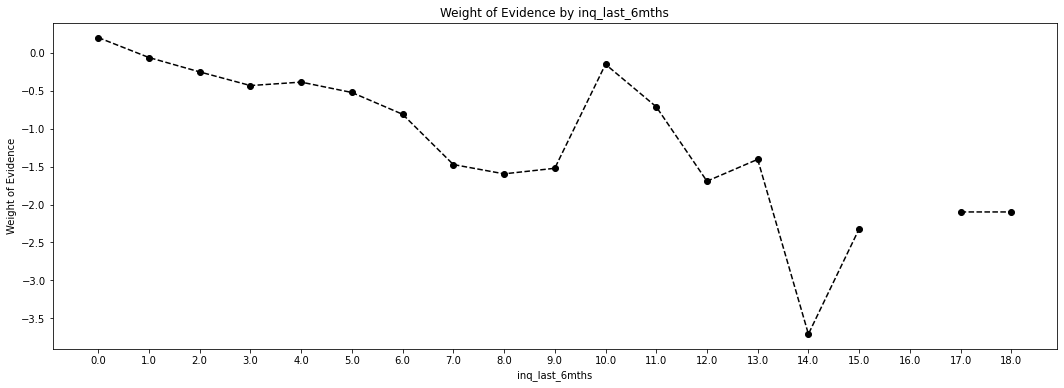

In [71]:
df_temp = PD_model.PD.WOE_continuous(x, 'inq_last_6mths', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp)

In [72]:
# Categories: 0, 1 - 2, 3 - 6, > 6
x['inq_last_6mths:0'] = np.where((x['inq_last_6mths'] == 0), 1, 0)
x['inq_last_6mths:1-2'] = np.where((x['inq_last_6mths'] >= 1) & (x['inq_last_6mths'] <= 2), 1, 0)
x['inq_last_6mths:3-6'] = np.where((x['inq_last_6mths'] >= 3) & (x['inq_last_6mths'] <= 6), 1, 0)
x['inq_last_6mths:>6'] = np.where((x['inq_last_6mths'] > 6), 1, 0)

9.open_acc

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


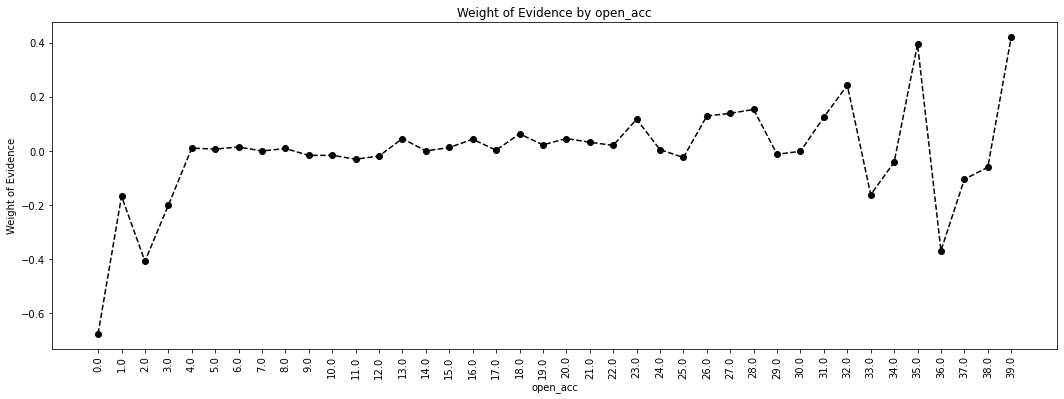

In [73]:
df_temp = PD_model.PD.WOE_continuous(x, 'open_acc', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp.iloc[ : 40, :], 90)

In [74]:
# Categories: '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
x['open_acc:0'] = np.where((x['open_acc'] == 0), 1, 0)
x['open_acc:1-3'] = np.where((x['open_acc'] >= 1) & (x['open_acc'] <= 3), 1, 0)
x['open_acc:4-12'] = np.where((x['open_acc'] >= 4) & (x['open_acc'] <= 12), 1, 0)
x['open_acc:13-17'] = np.where((x['open_acc'] >= 13) & (x['open_acc'] <= 17), 1, 0)
x['open_acc:18-22'] = np.where((x['open_acc'] >= 18) & (x['open_acc'] <= 22), 1, 0)
x['open_acc:23-25'] = np.where((x['open_acc'] >= 23) & (x['open_acc'] <= 25), 1, 0)
x['open_acc:26-30'] = np.where((x['open_acc'] >= 26) & (x['open_acc'] <= 30), 1, 0)
x['open_acc:>=31'] = np.where((x['open_acc'] >= 31), 1, 0)

10.pub_rec

/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


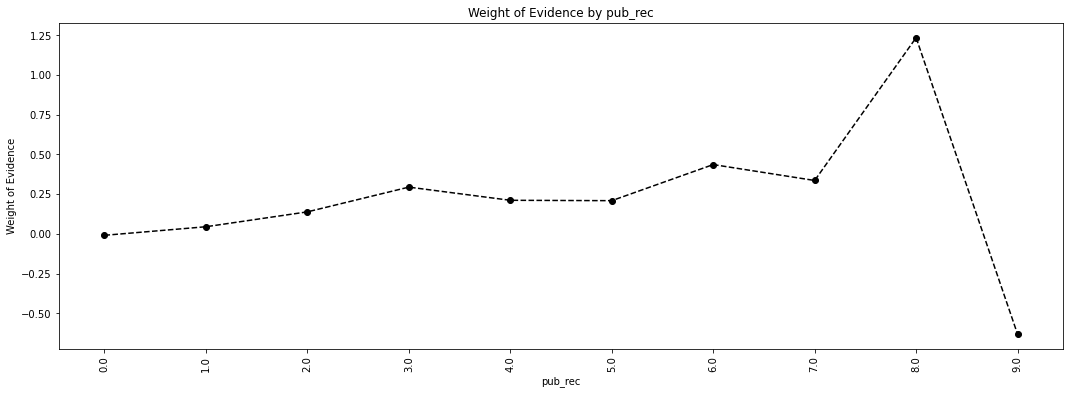

In [75]:
df_temp = PD_model.PD.WOE_continuous(x, 'pub_rec', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp, 90)

In [76]:
# Categories '0-2', '3-4', '>=5'
x['pub_rec:0-2'] = np.where((x['pub_rec'] >= 0) & (x['pub_rec'] <= 2), 1, 0)
x['pub_rec:3-4'] = np.where((x['pub_rec'] >= 3) & (x['pub_rec'] <= 4), 1, 0)
x['pub_rec:>=5'] = np.where((x['pub_rec'] >= 5), 1, 0)

11.total_acc


/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


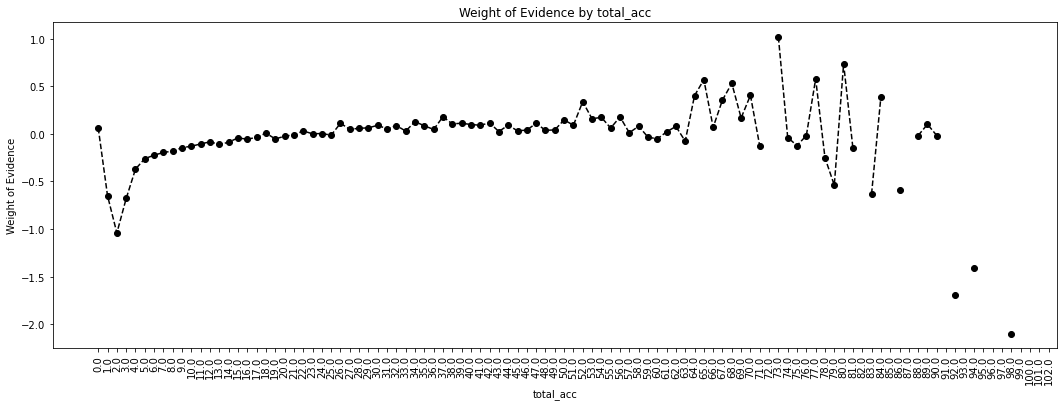

In [77]:
x['total_acc_factor'] = pd.cut(x['total_acc'], 50)
df_temp = PD_model.PD.WOE_continuous(x, 'total_acc', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp, 90)

In [78]:
# Categories: '<=27', '28-51', '>51'
x['total_acc:<=27'] = np.where((x['total_acc'] <= 27), 1, 0)
x['total_acc:28-51'] = np.where((x['total_acc'] >= 28) & (x['total_acc'] <= 51), 1, 0)
x['total_acc:>=52'] = np.where((x['total_acc'] >= 52), 1, 0)

12.acc_now_delinq

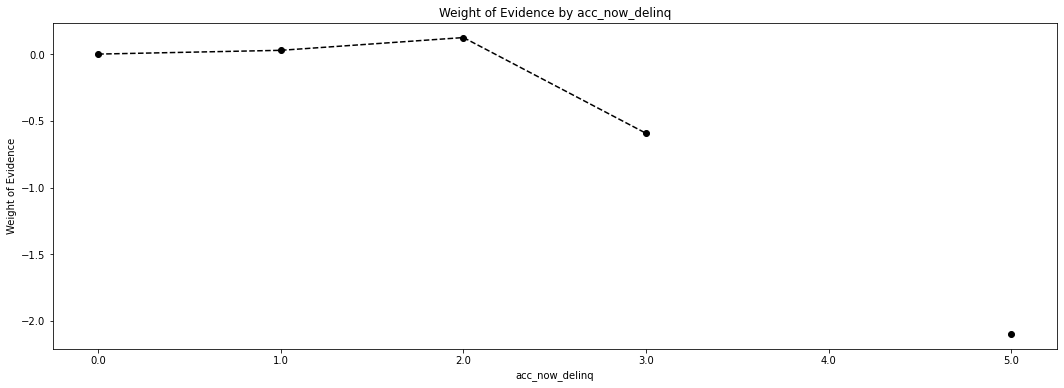

In [79]:
df_temp = PD_model.PD.WOE_continuous(x, 'acc_now_delinq', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp)

In [80]:
# Categories: '0', '>=1'
x['acc_now_delinq:0'] = np.where((x['acc_now_delinq'] == 0), 1, 0)
x['acc_now_delinq:>=1'] = np.where((x['acc_now_delinq'] >= 1), 1, 0)

13.total_rev_hi_lim

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


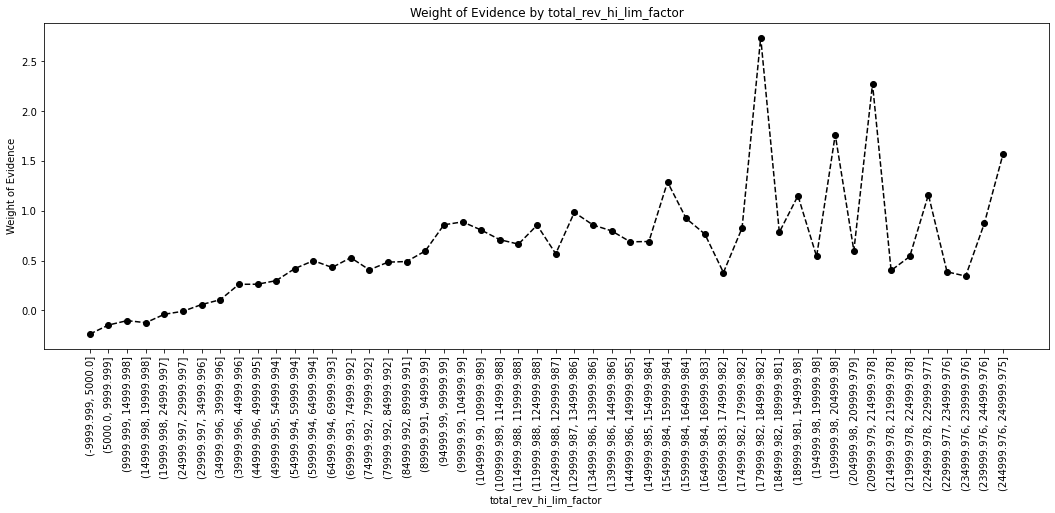

In [81]:
x['total_rev_hi_lim_factor'] = pd.cut(x['total_rev_hi_lim'], 2000)
df_temp = PD_model.PD.WOE_continuous(x, 'total_rev_hi_lim_factor', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp.iloc[: 50, : ], 90)

In [82]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
x['total_rev_hi_lim:<=5K'] = np.where((x['total_rev_hi_lim'] <= 5000), 1, 0)
x['total_rev_hi_lim:5K-10K'] = np.where((x['total_rev_hi_lim'] > 5000) & (x['total_rev_hi_lim'] <= 10000), 1, 0)
x['total_rev_hi_lim:10K-20K'] = np.where((x['total_rev_hi_lim'] > 10000) & (x['total_rev_hi_lim'] <= 20000), 1, 0)
x['total_rev_hi_lim:20K-30K'] = np.where((x['total_rev_hi_lim'] > 20000) & (x['total_rev_hi_lim'] <= 30000), 1, 0)
x['total_rev_hi_lim:30K-40K'] = np.where((x['total_rev_hi_lim'] > 30000) & (x['total_rev_hi_lim'] <= 40000), 1, 0)
x['total_rev_hi_lim:40K-55K'] = np.where((x['total_rev_hi_lim'] > 40000) & (x['total_rev_hi_lim'] <= 55000), 1, 0)
x['total_rev_hi_lim:55K-95K'] = np.where((x['total_rev_hi_lim'] > 55000) & (x['total_rev_hi_lim'] <= 95000), 1, 0)
x['total_rev_hi_lim:>95K'] = np.where((x['total_rev_hi_lim'] > 95000), 1, 0)

14.installment

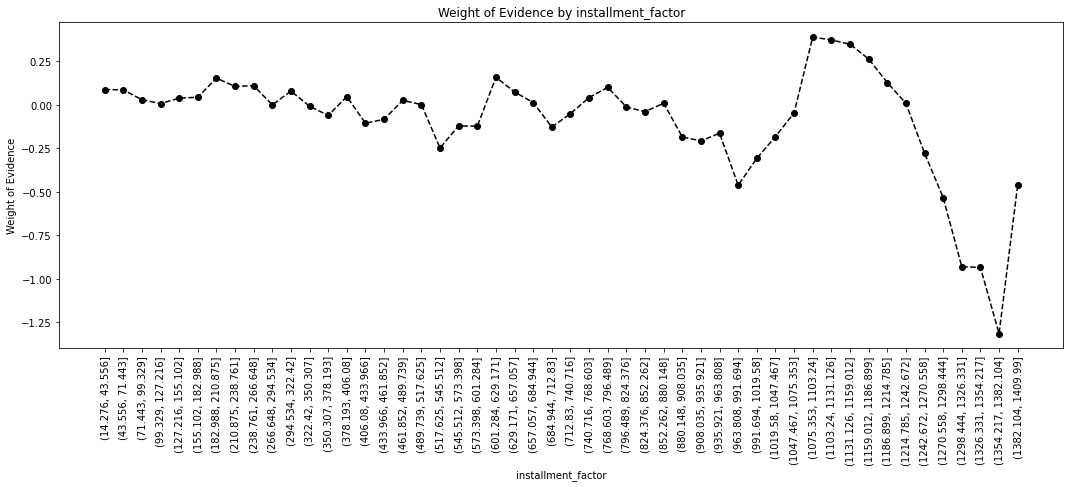

In [83]:
x['installment_factor'] = pd.cut(x['installment'], 50)
df_temp = PD_model.PD.WOE_continuous(x, 'installment_factor', y)
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp, 90)

15.annual_inc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


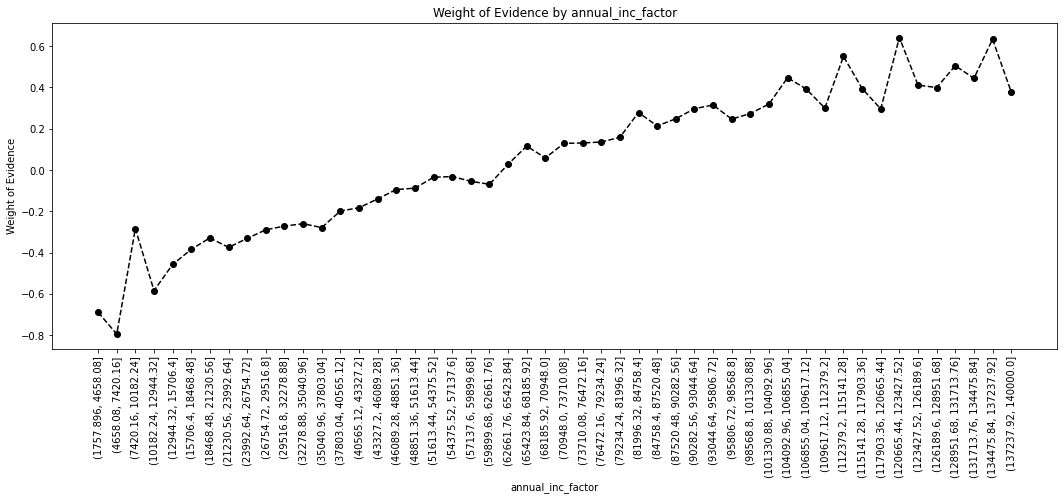

In [84]:
x['annual_inc_factor'] = pd.cut(x['annual_inc'], 100)
x_temp = x.loc[x['annual_inc'] <= 140000, : ]
x_temp["annual_inc_factor"]=pd.cut(x_temp['annual_inc'],50)
df_temp = PD_model.PD.WOE_continuous(x_temp, 'annual_inc_factor', y[x_temp.index])
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp, 90)

In [85]:
# WoE is monotonically decreasing with income, so we split income in 10 equal categories, each with width of 15k.
x['annual_inc:<20K'] = np.where((x['annual_inc'] <= 20000), 1, 0)
x['annual_inc:20K-30K'] = np.where((x['annual_inc'] > 20000) & (x['annual_inc'] <= 30000), 1, 0)
x['annual_inc:30K-40K'] = np.where((x['annual_inc'] > 30000) & (x['annual_inc'] <= 40000), 1, 0)
x['annual_inc:40K-50K'] = np.where((x['annual_inc'] > 40000) & (x['annual_inc'] <= 50000), 1, 0)
x['annual_inc:50K-60K'] = np.where((x['annual_inc'] > 50000) & (x['annual_inc'] <= 60000), 1, 0)
x['annual_inc:60K-70K'] = np.where((x['annual_inc'] > 60000) & (x['annual_inc'] <= 70000), 1, 0)
x['annual_inc:70K-80K'] = np.where((x['annual_inc'] > 70000) & (x['annual_inc'] <= 80000), 1, 0)
x['annual_inc:80K-90K'] = np.where((x['annual_inc'] > 80000) & (x['annual_inc'] <= 90000), 1, 0)
x['annual_inc:90K-100K'] = np.where((x['annual_inc'] > 90000) & (x['annual_inc'] <= 100000), 1, 0)
x['annual_inc:100K-120K'] = np.where((x['annual_inc'] > 100000) & (x['annual_inc'] <= 120000), 1, 0)
x['annual_inc:120K-140K'] = np.where((x['annual_inc'] > 120000) & (x['annual_inc'] <= 140000), 1, 0)
x['annual_inc:>140K'] = np.where((x['annual_inc'] > 140000), 1, 0)

16.mths_since_last_delinq

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


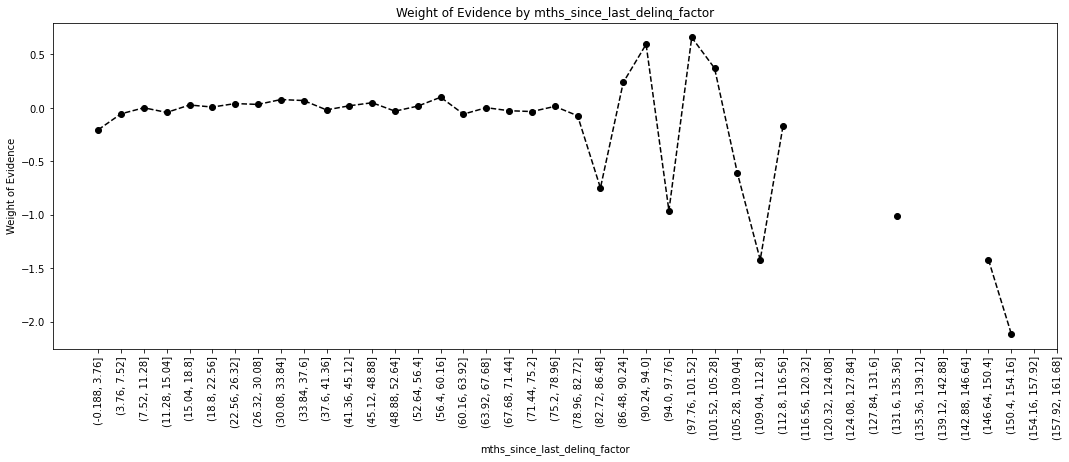

In [86]:
x_temp = x[pd.notnull(x['mths_since_last_delinq'])]
x_temp['mths_since_last_delinq_factor'] = pd.cut(x_temp['mths_since_last_delinq'], 50)
df_temp = PD_model.PD.WOE_continuous(x_temp,'mths_since_last_delinq_factor', y[x_temp.index])
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp, 90)

In [87]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
x['mths_since_last_delinq:Missing'] = np.where((x['mths_since_last_delinq'].isnull()), 1, 0)
x['mths_since_last_delinq:0-3'] = np.where((x['mths_since_last_delinq'] >= 0) & (x['mths_since_last_delinq'] <= 3), 1, 0)
x['mths_since_last_delinq:4-30'] = np.where((x['mths_since_last_delinq'] >= 4) & (x['mths_since_last_delinq'] <= 30), 1, 0)
x['mths_since_last_delinq:31-56'] = np.where((x['mths_since_last_delinq'] >= 31) & (x['mths_since_last_delinq'] <= 56), 1, 0)
x['mths_since_last_delinq:>=57'] = np.where((x['mths_since_last_delinq'] >= 57), 1, 0)

17.dti

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


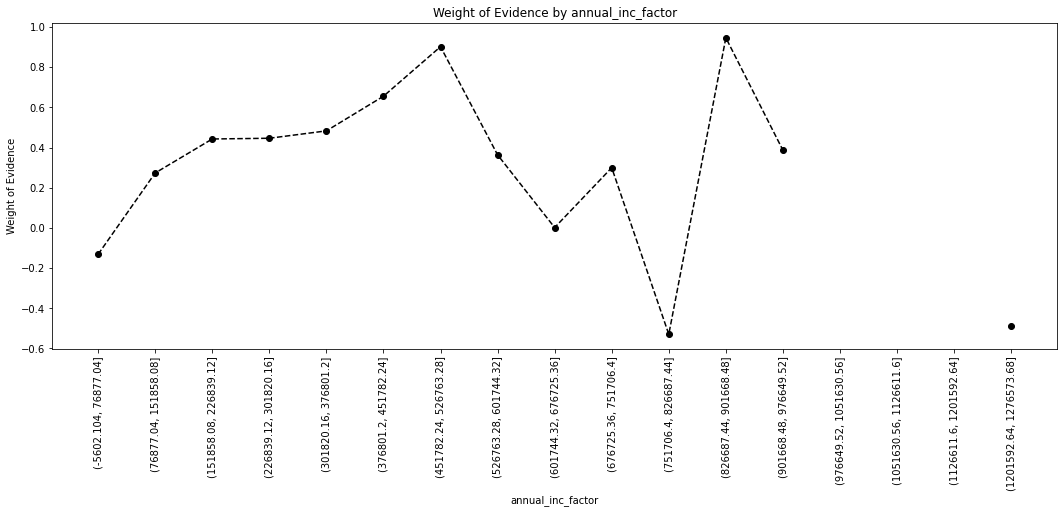

In [88]:
x['dti_factor'] = pd.cut(x['dti'], 100)
x_temp = x.loc[x['dti'] <= 35, : ]
x_temp['dti_facto']=pd.cut(x_temp['dti'],50)
df_temp = PD_model.PD.WOE_continuous(x_temp, 'annual_inc_factor', y[x_temp.index])
df_temp = PD_model.PD.IV(df_temp)
PD_model.PD.plot_by_woe(df_temp, 90)

In [89]:
# Categories:
x['dti:<=1.4'] = np.where((x['dti'] <= 1.4), 1, 0)
x['dti:1.4-3.5'] = np.where((x['dti'] > 1.4) & (x['dti'] <= 3.5), 1, 0)
x['dti:3.5-7.7'] = np.where((x['dti'] > 3.5) & (x['dti'] <= 7.7), 1, 0)
x['dti:7.7-10.5'] = np.where((x['dti'] > 7.7) & (x['dti'] <= 10.5), 1, 0)
x['dti:10.5-16.1'] = np.where((x['dti'] > 10.5) & (x['dti'] <= 16.1), 1, 0)
x['dti:16.1-20.3'] = np.where((x['dti'] > 16.1) & (x['dti'] <= 20.3), 1, 0)
x['dti:20.3-21.7'] = np.where((x['dti'] > 20.3) & (x['dti'] <= 21.7), 1, 0)
x['dti:21.7-22.4'] = np.where((x['dti'] > 21.7) & (x['dti'] <= 22.4), 1, 0)
x['dti:22.4-35'] = np.where((x['dti'] > 22.4) & (x['dti'] <= 35), 1, 0)
x['dti:>35'] = np.where((x['dti'] > 35), 1, 0)

### Splitting data

80% train data & 20% test data

In [72]:
train_x,test_x,train_y,test_y = train_test_split(x,
                                                 y,
                                                 test_size = 0.2, random_state = 42)

In [73]:
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(373028, 235) (93257, 235) (373028,) (93257,)


In [74]:
train_x.to_csv('loan_data_inputs_train.csv')
train_y.to_csv('loan_data_targets_train.csv')
test_x.to_csv('loan_data_inputs_test.csv')
test_y.to_csv('loan_data_targets_test.csv')

### upload the data back to s3 bucket

In [ ]:
bucket.upload_file(Filename='loan_data_inputs_train.csv',Key='credit-risk-model/loan_data_inputs_train.csv')

In [ ]:
bucket.upload_file(Filename='loan_data_targets_train.csv',Key='credit-risk-model/loan_data_targets_train.csv')

In [ ]:
bucket.upload_file(Filename='loan_data_inputs_test.csv',Key='credit-risk-model/loan_data_inputs_test.csv')

In [ ]:
bucket.upload_file(Filename='loan_data_targets_test.csv',Key='credit-risk-model/loan_data_targets_test.csv')